In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# load development set

df_dev = pd.read_csv('dev.tsv',sep='\t')
df_dev

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0
...,...,...,...,...,...,...,...,...,...
120739,Italy,This is a lovely Sauvignon with very character...,NaN,Northeastern Italy,Friuli,NaN,Sauvignon,Plozner,40.0
120740,Spain,"Opens somewhat clipped and choppy, with citrus...",Reserva,Northern Spain,Rioja,NaN,Tempranillo Blend,Ramón Bilbao,41.0
120741,Australia,Surprisingly complete and harmonious for a Rie...,NaN,South Australia,Adelaide Hills,NaN,Riesling,Wagtail,26.0
120742,Germany,Broad aromas of ripe yellow fruit and a hint o...,Spätlese,Mosel,NaN,NaN,Riesling,Pamona Cellars,26.0


In [3]:
df_dev.describe()

,quality
count,120744.000000
mean,46.277852
std,11.924781
min,0.000000
25%,38.000000
50%,46.000000
75%,55.000000
max,100.000000


In [4]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


In [5]:
df_dev[['country','designation','province','region_1','region_2','winery','variety']].nunique().sum()

44224

In [6]:
df_dev['country'].nunique()

48

In [7]:
# drop duplicates in df_dev

df_dev = df_dev.drop_duplicates()

In [8]:
df_eval = pd.read_csv('eval.tsv',sep='\t')
df_eval.head()

,country,description,designation,province,region_1,region_2,variety,winery
0,US,Strong blueberry and black-cherry aromas mesh ...,Alliage,California,Santa Cruz Mountains,Central Coast,Cabernet Sauvignon,Byington
1,Germany,"Lush and decadent, with intensely sweet notes ...",Graacher Himmelreich Vat 69 Eiswein,Mosel,NaN,NaN,Riesling,S.A. Prüm
2,Spain,"Leather, mint and wet-dog aromas along with an...",Cachito Mio,Northern Spain,Toro,NaN,Tinta de Toro,La Casa Maguila
3,France,"92-94 Barrel sample. Wood dominant, smooth tan...",Barrel sample,Bordeaux,Saint-Julien,NaN,Bordeaux-style Red Blend,Château Branaire-Ducru
4,France,"A lean, austere wine, maybe the result of the ...",Tradition,Southwest France,Cahors,NaN,Malbec,Château les Croisille


In [9]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30186 entries, 0 to 30185
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      30186 non-null  object
 1   description  30186 non-null  object
 2   designation  20969 non-null  object
 3   province     30186 non-null  object
 4   region_1     25134 non-null  object
 5   region_2     12217 non-null  object
 6   variety      30186 non-null  object
 7   winery       30186 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB


In [10]:
df_eval[['country','designation','province','region_1','region_2','winery','variety']].nunique().sum()

22718

In [11]:
df_eval['country'].nunique()

40

In [12]:
df = pd.concat([df_dev,df_eval],sort=False,ignore_index=True)
df = df[df['country'].notnull() & df['province'].notnull()]
df = df.assign(desc_length = df['description'].apply(len))
df

,country,description,designation,province,region_1,region_2,variety,winery,quality,desc_length
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0,184
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0,133
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0,202
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0,210
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0,237
...,...,...,...,...,...,...,...,...,...,...
115209,US,This is very good in a Napa-does-Bordeaux styl...,Blueprint,California,Napa Valley,Napa,Bordeaux-style Red Blend,Lail,NaN,148
115210,US,You might mistake this for a good Dry Creek Zi...,NaN,California,Dry Creek Valley,Sonoma,Cabernet Franc,Mounts,NaN,226
115211,US,"A Southern Rhône-style blend of Syrah, Grenach...",Cuvee Christie,California,Santa Barbara County,Central Coast,G-S-M,Tercero,NaN,233
115212,South Africa,"Fresh grass, vibrant citrus and tart gooseberr...",Polkadraai,Polkadraai Hills,NaN,NaN,Chenin Blanc-Sauvignon Blanc,Stellenbosch Hills,NaN,227


In [13]:
df[['country','designation','province','region_1','region_2','winery','variety']].nunique().sum()

47816

In [14]:
df['country'].nunique()

48

## Dealing with region_2

In [15]:
df[pd.isna(df['region_2'])]

,country,description,designation,province,region_1,region_2,variety,winery,quality,desc_length
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0,184
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0,210
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0,237
5,New Zealand,Classic gooseberry and pink grapefruit notes f...,NaN,Marlborough,NaN,NaN,Sauvignon Blanc,Cloudy Bay,48.0,187
9,Italy,The complexity starts with dusty mineral tones...,Gabbro,Tuscany,Toscana,NaN,Cabernet Sauvignon,Montepeloso,70.0,257
...,...,...,...,...,...,...,...,...,...,...
115203,Italy,"Golden with amber highlights, this sweet vine-...",NaN,Northeastern Italy,Colli Orientali del Friuli,NaN,Verduzzo Friulano,Colutta,NaN,233
115204,Argentina,The nose is yeasty with aromas of apple and ha...,Brut Methode Traditionnelle,Mendoza Province,Tupungato,NaN,Champagne Blend,Domaine Jean Bousquet,NaN,220
115206,Portugal,Old vines in this case means 70-year-old vines...,Reserva Old Vines,Douro,NaN,NaN,Portuguese Red,Quinta do Crasto,NaN,197
115208,Spain,"Waxy on the nose, with buttercup, creamy yello...",NaN,Northern Spain,Somontano,NaN,Chardonnay,Viñas del Vero,NaN,271


In [16]:
len(df[(~pd.isna(df.region_1)) & (pd.isna(df.region_2))])

49762

In [17]:
len(df[(pd.isna(df.region_1)) & (pd.isna(df.region_2))])

18938

In [18]:
len(df[pd.isna(df.region_2)])

68700

In [19]:
# if region_2 is present, substitute region_1 with region_2 value (more specific geographical info)
mask = ~pd.isna(df.region_2)
df.loc[mask,'region_1'] = df.loc[mask,'region_2']
df = df.drop(columns=['region_2'])
df

,country,description,designation,province,region_1,variety,winery,quality,desc_length
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,Pinot Blanc,Lucien Albrecht,45.0,184
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Central Coast,Cabernet Sauvignon,Castle Rock,31.0,133
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Gewürztraminer,Château Bianca,35.0,202
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,Touriga Nacional,Herdade do Esporão,41.0,210
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,Coda di Volpe,Sorrentino,37.0,237
...,...,...,...,...,...,...,...,...,...
115209,US,This is very good in a Napa-does-Bordeaux styl...,Blueprint,California,Napa,Bordeaux-style Red Blend,Lail,NaN,148
115210,US,You might mistake this for a good Dry Creek Zi...,NaN,California,Sonoma,Cabernet Franc,Mounts,NaN,226
115211,US,"A Southern Rhône-style blend of Syrah, Grenach...",Cuvee Christie,California,Central Coast,G-S-M,Tercero,NaN,233
115212,South Africa,"Fresh grass, vibrant citrus and tart gooseberr...",Polkadraai,Polkadraai Hills,NaN,Chenin Blanc-Sauvignon Blanc,Stellenbosch Hills,NaN,227


# EDA

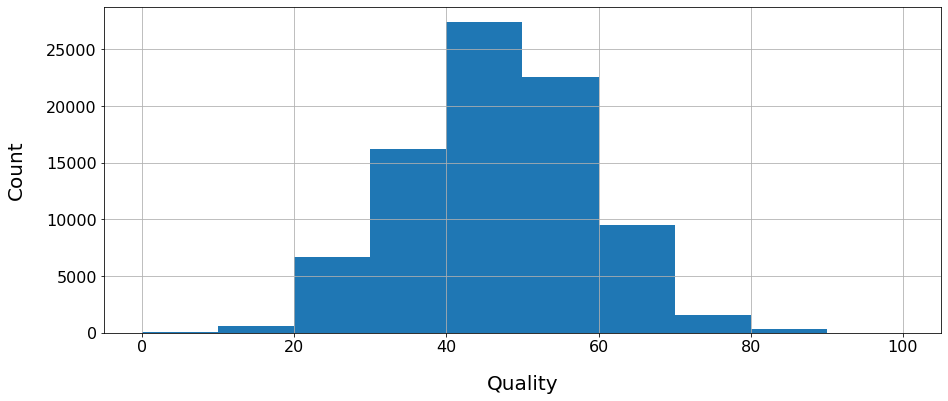

In [20]:
# quality distribution

plt.figure(figsize=(15,6))
plt.hist(df_dev['quality'])
plt.xlabel('Quality',fontsize=20,labelpad=20)
plt.ylabel('Count',fontsize=20,labelpad=20)
plt.tick_params(labelsize=16)
plt.grid(True)
# plt.savefig("fig1.svg",format='svg')
plt.show()

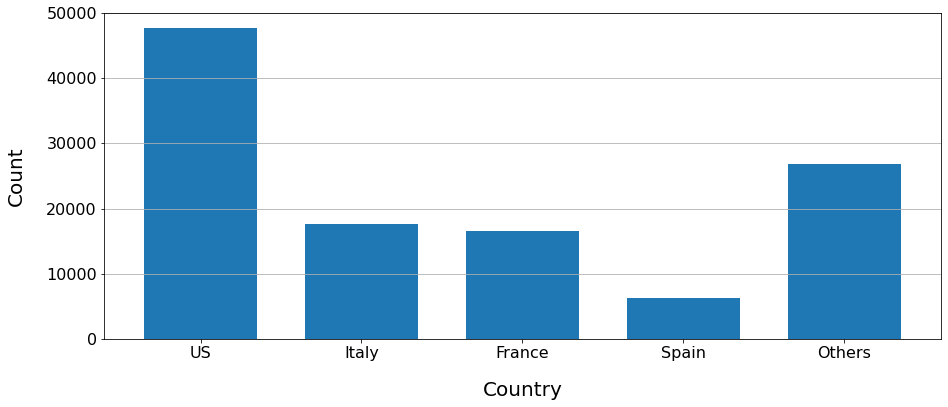

In [21]:
# records per country

df_countries = copy.deepcopy(df)
df_countries.loc[~(df['country']).isin(['US','Italy','France','Spain']),:] = 'Others'
top_countries = df['country'].value_counts().head(4)
len_others = len(df_countries[df_countries['country']=='Others'])
temp_dict = top_countries.to_dict()
temp_dict['Others'] = len_others
temp_series = pd.Series(temp_dict)

plt.figure(figsize=(15,6))
temp_series.plot(kind='bar',width=0.7)
plt.xlabel('Country',fontsize=20,labelpad=20)
plt.ylabel('Count',fontsize=20,labelpad=20)
plt.tick_params(labelsize=16)
plt.grid(True,axis='y')
plt.xticks(rotation=0)
# plt.savefig("fig2.svg",format='svg')
plt.show()

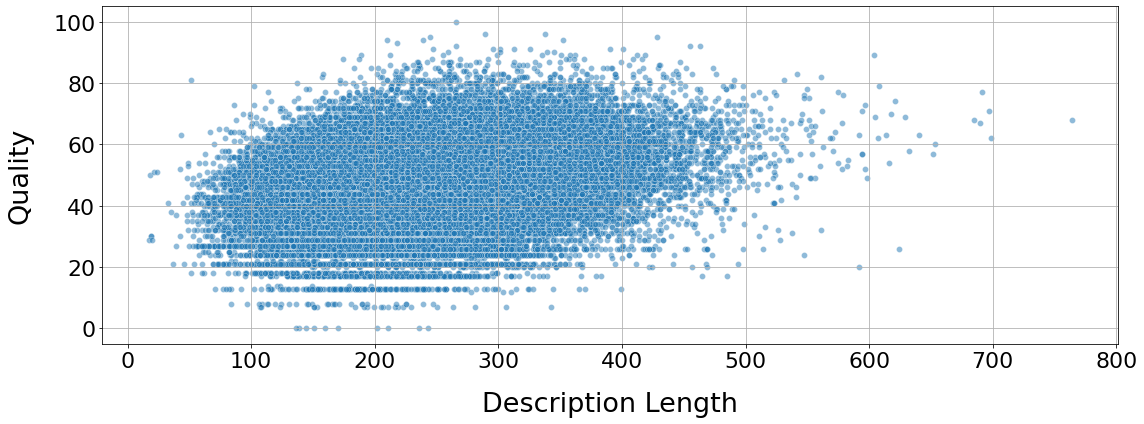

In [22]:
plt.figure(figsize=(16,6))
g = sns.scatterplot(x='desc_length', y='quality', data=df,alpha=0.5)
g.set_ylabel('Quality', fontsize=27,labelpad=20) 
g.set_xlabel('Description Length', fontsize=27,labelpad=20) 
plt.tick_params(labelsize=22)
plt.tight_layout()
plt.grid()
# plt.savefig("fig3.svg",format='svg')
plt.show()

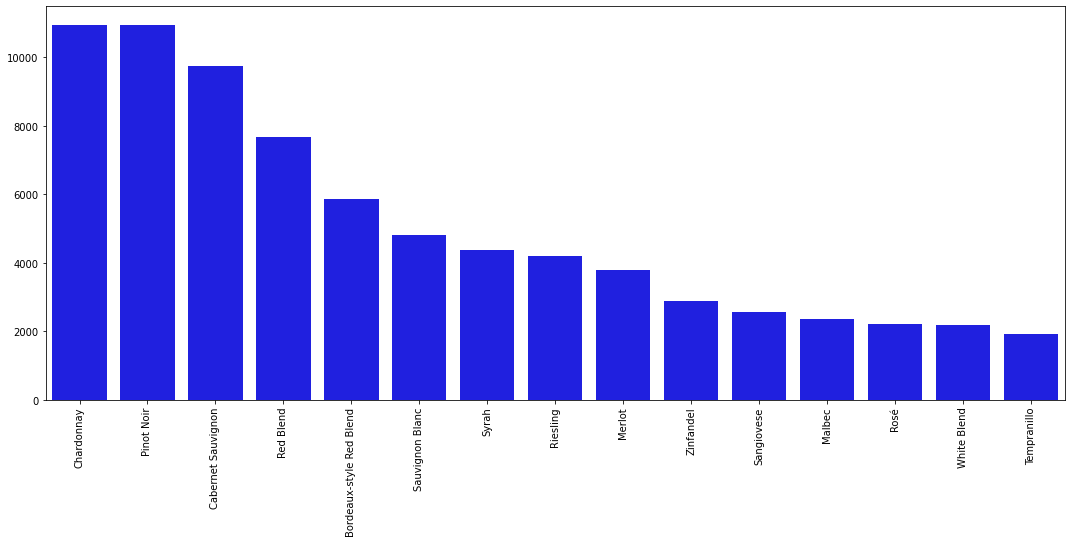

In [23]:
top_varieties = df['variety'].value_counts().head(15)

plt.figure(figsize=(15,6))
sns.barplot(x=top_varieties.index, y=top_varieties.values,color='b')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

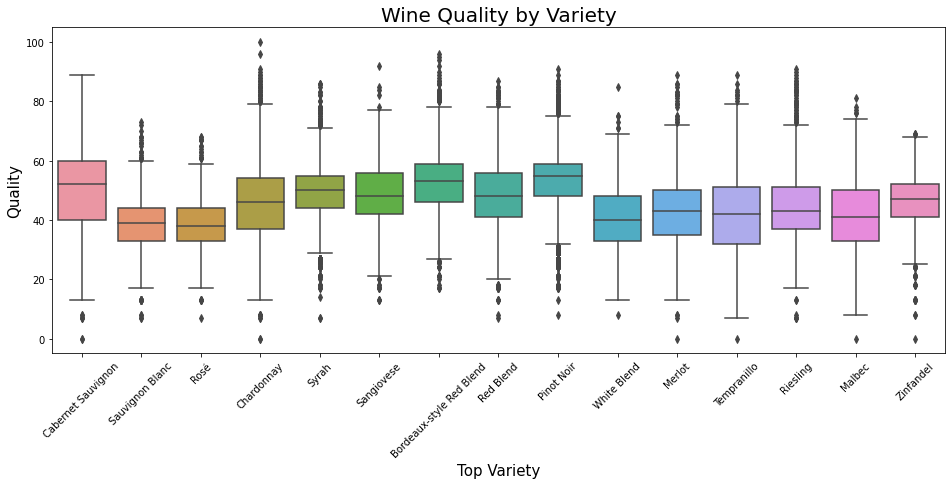

In [24]:
plt.figure(figsize=(16,6))

g = sns.boxplot(x='variety', y='quality',data=df[df['variety'].isin(top_varieties.index)])
g.set_title("Wine Quality by Variety", fontsize=20)
g.set_xlabel("Top Variety", fontsize=15)
g.set_ylabel("Quality", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

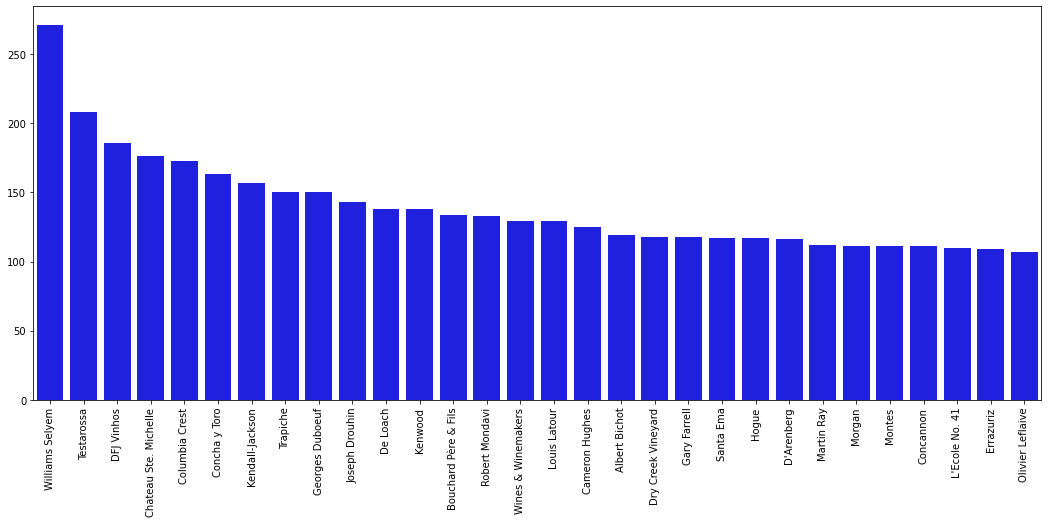

In [25]:
top_wineries = df['winery'].value_counts().head(30)

plt.figure(figsize=(15,6))
sns.barplot(x=top_wineries.index, y=top_wineries.values,color='b')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

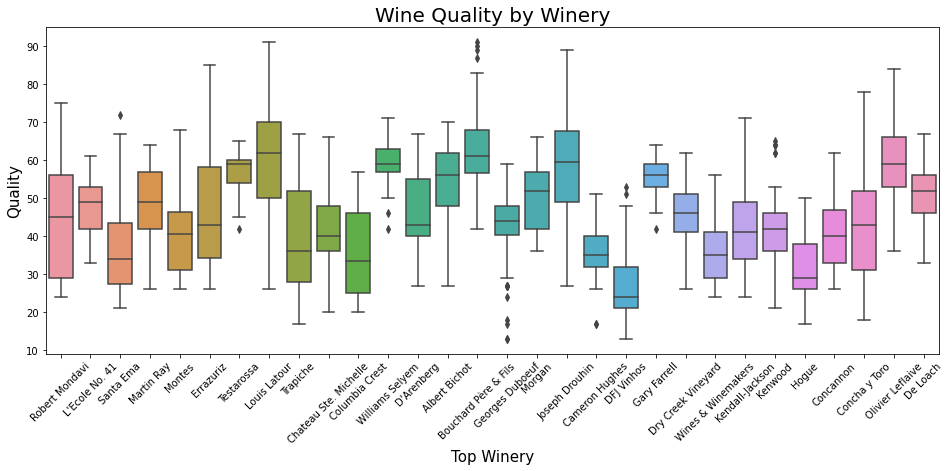

In [26]:
plt.figure(figsize=(16,6))

g = sns.boxplot(x='winery', y='quality',data=df[df['winery'].isin(top_wineries.index)])
g.set_title("Wine Quality by Winery", fontsize=20)
g.set_xlabel("Top Winery", fontsize=15)
g.set_ylabel("Quality", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

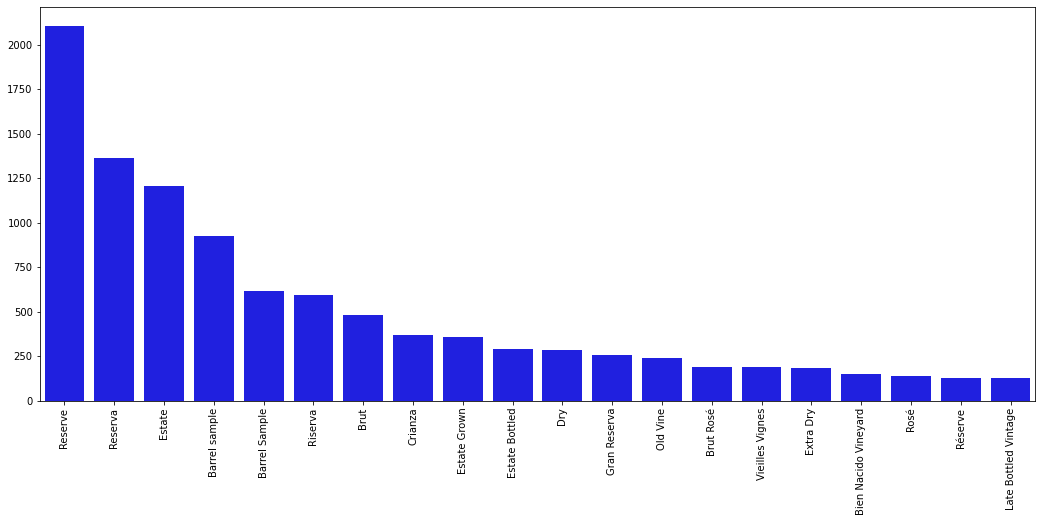

In [27]:
top_designations = df['designation'].value_counts().head(20)

plt.figure(figsize=(15,6))
sns.barplot(x=top_designations.index, y=top_designations.values,color='b')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

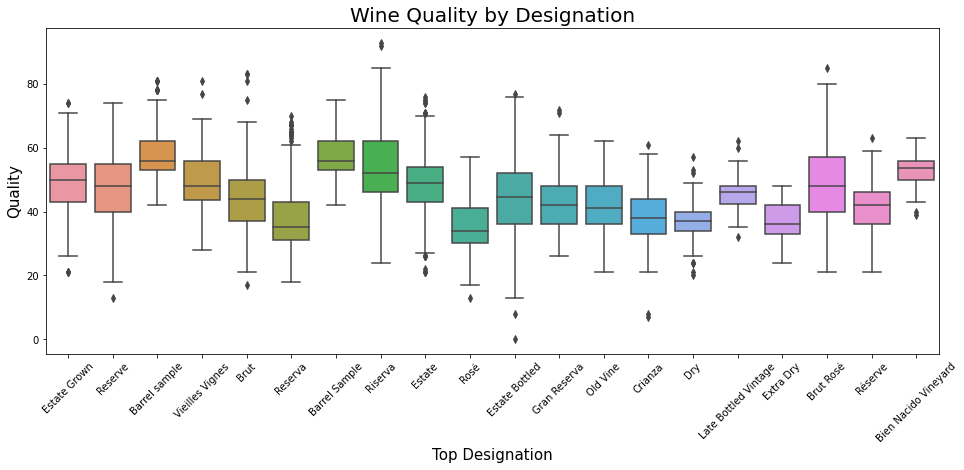

In [28]:
plt.figure(figsize=(16,6))

g = sns.boxplot(x='designation', y='quality',data=df[df['designation'].isin(top_designations.index)])
g.set_title("Wine Quality by Designation", fontsize=20)
g.set_xlabel("Top Designation", fontsize=15)
g.set_ylabel("Quality", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

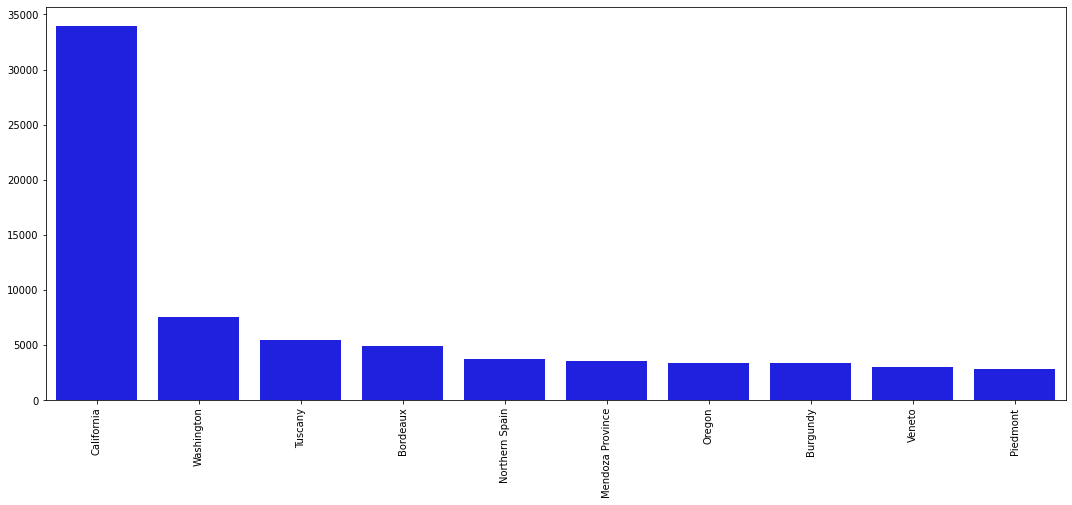

In [29]:
top_provinces = df['province'].value_counts().head(10)

plt.figure(figsize=(15,6))
sns.barplot(x=top_provinces.index, y=top_provinces.values,color='b')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

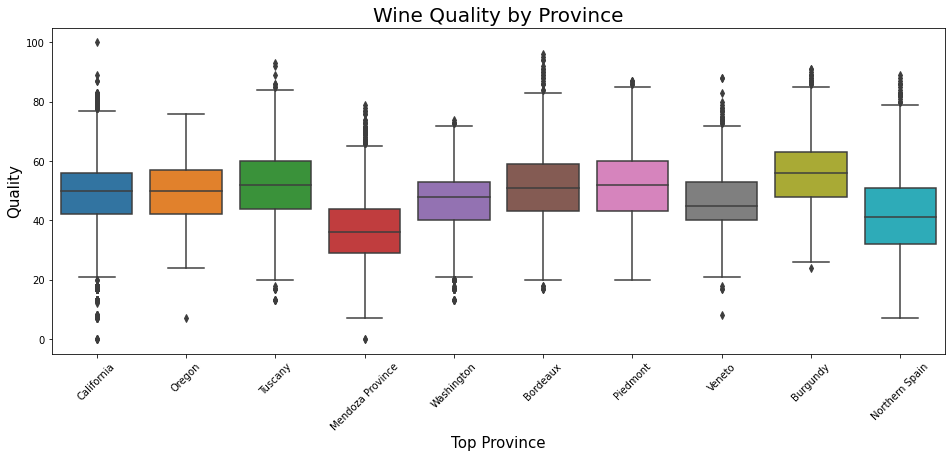

In [30]:
plt.figure(figsize=(16,6))

g = sns.boxplot(x='province', y='quality',data=df[df['province'].isin(top_provinces.index)])
g.set_title("Wine Quality by Province", fontsize=20)
g.set_xlabel("Top Province", fontsize=15)
g.set_ylabel("Quality", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

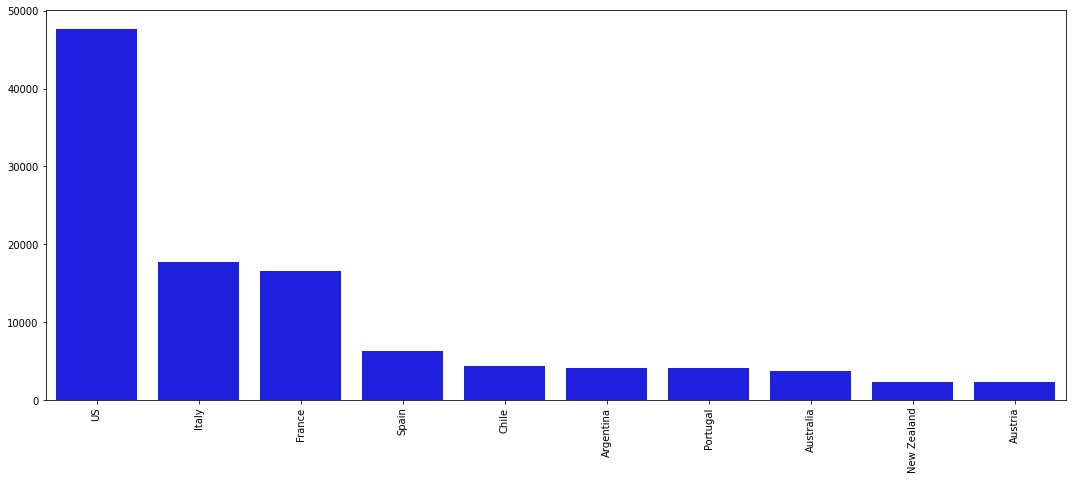

In [31]:
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(15,6))
sns.barplot(x=top_countries.index, y=top_countries.values,color='b')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

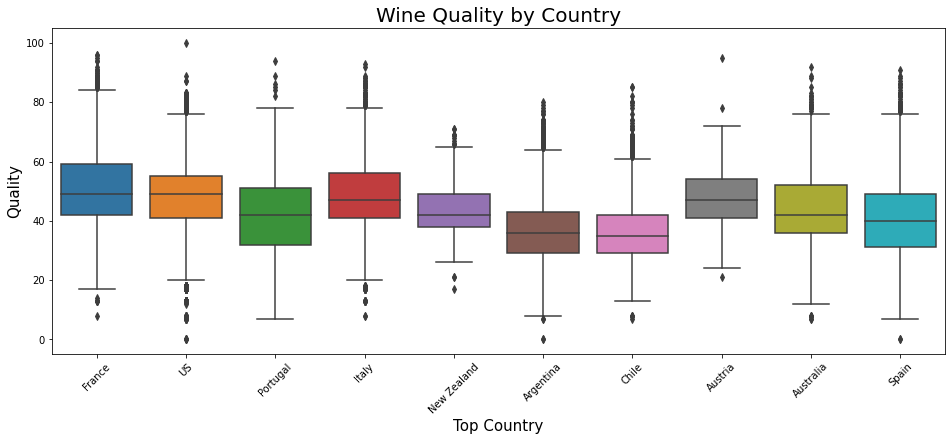

In [32]:
plt.figure(figsize=(16,6))

g = sns.boxplot(x='country', y='quality',data=df[df['country'].isin(top_countries.index)])
g.set_title("Wine Quality by Country", fontsize=20)
g.set_xlabel("Top Country", fontsize=15)
g.set_ylabel("Quality", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

## GROUPBY

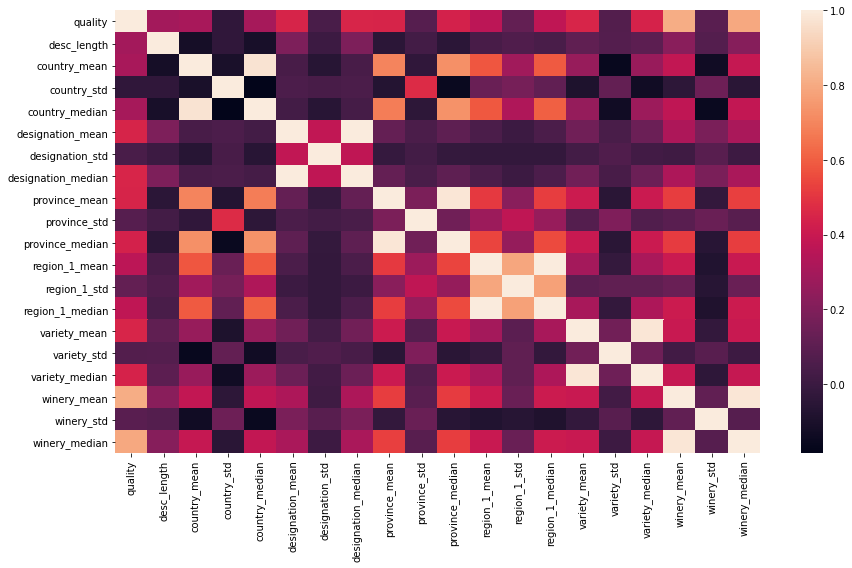

In [33]:
df_grp = copy.deepcopy(df)

# statistics
transformations = ['mean','std','median']
cols_to_transform = ['country','designation','province','region_1','variety','winery']
for col in cols_to_transform:
    for transf in transformations:
        col_name = f"{col}_{transf}"
        df_grp[col_name] = df_grp.groupby(col)['quality'].transform(transf)

df_grp = df_grp.drop(columns=cols_to_transform)
df_grp = df_grp.drop(columns=['description'])
df_dev = df_grp.loc[~pd.isna(df_grp['quality']),:]
df_dev = df_dev.fillna(0)

plt.figure(figsize = (13,8))
sns.heatmap(df_dev.corr())
# plt.savefig("fig4.svg",format='svg')
plt.tight_layout()
plt.show()

# Mean smoothing & adding skew, kurtosis

In [34]:
# coefficient eta (m) of smoothed mean is usually around 300, check from 0 to 550, step 50

m_vect = np.arange(0,600,50)
m_vect

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])

In [35]:
mse_vect = []

for m in m_vect: 
    print(f'Processing with m = {m}')
    df_grp = copy.deepcopy(df)

    # statistics and mean smoothing
    transformations = ['skew','std']
    cols_to_transform = ['country','designation','province','region_1','variety','winery']
    for col in cols_to_transform:
        for transf in transformations:
            col_name = f"{col}_{transf}"
            df_grp[col_name] = df_grp.groupby(col)['quality'].transform(transf)
        df_grp[f'{col}_kurtosis'] = df[col].map(df.groupby(col)['quality'].apply(pd.DataFrame.kurt))

    global_mean = df['quality'].mean()

    for col in cols_to_transform:
        agg = df.groupby(col)['quality'].agg(['count','mean'])
        counts = agg['count']
        means = agg['mean']
        smooth = (counts * means + m * global_mean) / (counts + m)
        col_name = f"{col}_mean"
        df_grp[col_name] = df[col].map(smooth)

    df_grp = df_grp.drop(columns=cols_to_transform)
    df_grp = df_grp.drop(columns=['description','region_1_std'])  # remov reg_1_std because of heatmap
    
    df_dev = df_grp.loc[~pd.isna(df_grp['quality']),:]
    df_eval = df_grp.loc[pd.isna(df_grp['quality']),:]
    df_eval.index = range(len(df_eval))
    df_dev.index = range(len(df_dev))
    df_dev = df_dev.fillna(0)
    
    X = df_dev.drop(columns=['quality'])
    y = df_dev['quality']
    X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.2)
    
    reg = RandomForestRegressor(n_estimators=100,random_state=42,max_features='sqrt',n_jobs=-2)
    reg.fit(X_train , y_train)
    y_pred = reg.predict(X_test)
    mse_vect.append(mean_squared_error(y_test, y_pred))

Processing with m = 0
Processing with m = 50
Processing with m = 100
Processing with m = 150
Processing with m = 200
Processing with m = 250
Processing with m = 300
Processing with m = 350
Processing with m = 400
Processing with m = 450
Processing with m = 500
Processing with m = 550


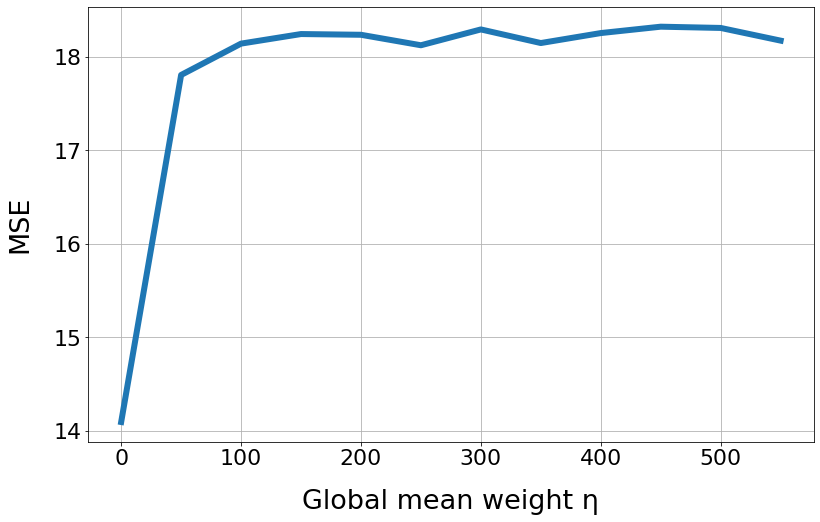

In [36]:
plt.figure(figsize = (13,8))
plt.grid()
plt.xlabel('Global mean weight η',fontsize=27,labelpad=20)
plt.ylabel('MSE',fontsize=27,labelpad=20)
plt.tick_params(labelsize=22)
plt.plot(m_vect,mse_vect,linewidth=6)
# plt.savefig("fig5.png",format='png')

# Fit & predict with best m

In [40]:
# mse for m = 450 (max) has revealed as the less overfitted during our tests

best_m = m_vect[np.argmax(mse_vect)]
best_m

450

In [41]:
df_grp = copy.deepcopy(df)

# statistics and mean smoothing
transformations = ['skew','std']
cols_to_transform = ['country','designation','province','region_1','variety','winery']
for col in cols_to_transform:
    for transf in transformations:
        col_name = f"{col}_{transf}"
        df_grp[col_name] = df_grp.groupby(col)['quality'].transform(transf)
    df_grp[f'{col}_kurtosis'] = df[col].map(df.groupby(col)['quality'].apply(pd.DataFrame.kurt))

global_mean = df['quality'].mean()
m = best_m

for i,col in enumerate(cols_to_transform):
    agg = df.groupby(col)['quality'].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + m * global_mean) / (counts + m)
    col_name = f"{col}_mean"
    df_grp[col_name] = df[col].map(smooth)

df_grp = df_grp.drop(columns=cols_to_transform)

In [42]:
df_grp = df_grp.drop(columns=['description','region_1_std'])
df_grp

,quality,desc_length,country_skew,country_std,country_kurtosis,designation_skew,designation_std,designation_kurtosis,province_skew,province_std,...,variety_kurtosis,winery_skew,winery_std,winery_kurtosis,country_mean,designation_mean,province_mean,region_1_mean,variety_mean,winery_mean
0,45.0,184,0.171741,12.398494,-0.110675,-0.420535,10.001389,0.899648,0.368863,8.949013,...,-0.413773,0.551768,9.342922,0.066363,49.633382,46.285963,47.265751,46.045781,44.061826,46.593327
1,31.0,133,-0.250427,10.676969,0.033939,NaN,NaN,NaN,-0.318116,11.008766,...,-0.552701,1.019212,4.353032,0.101730,47.968116,NaN,48.710343,48.284363,49.695708,44.563360
2,35.0,202,-0.250427,10.676969,0.033939,NaN,NaN,NaN,-0.160990,9.216288,...,0.414318,-0.191434,3.255764,-1.072358,47.968116,NaN,48.947545,50.096846,44.766432,45.996252
3,41.0,210,0.112274,12.916277,-0.253035,NaN,NaN,NaN,0.032716,11.913265,...,0.085600,0.206069,10.672755,-0.927869,42.490287,NaN,43.429892,NaN,46.127973,45.718892
4,37.0,237,0.107210,11.326100,-0.155313,NaN,NaN,NaN,0.131302,9.281938,...,2.034193,1.004882,5.411628,0.163669,48.109033,46.401900,44.936262,46.443546,46.317260,46.346295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115209,NaN,148,-0.250427,10.676969,0.033939,-0.560000,2.500000,0.928000,-0.318116,11.008766,...,0.178129,0.250786,7.646973,-2.174119,47.968116,46.518187,48.710343,55.096436,52.400095,46.678899
115210,NaN,226,-0.250427,10.676969,0.033939,NaN,NaN,NaN,-0.318116,11.008766,...,0.293488,0.539810,4.672835,2.192301,47.968116,NaN,48.710343,50.329949,47.869034,46.637095
115211,NaN,233,-0.250427,10.676969,0.033939,NaN,0.000000,NaN,-0.318116,11.008766,...,1.060064,-0.782143,4.616740,-0.652657,47.968116,46.434197,48.710343,48.284363,46.579326,46.402703
115212,NaN,227,0.312904,10.612914,-0.450701,1.732051,4.041452,NaN,1.732051,4.041452,...,0.707013,1.080544,3.193744,-0.651672,41.475843,46.309618,46.309618,NaN,46.264883,46.233532


In [43]:
df_dev = df_grp.loc[~pd.isna(df_grp['quality']),:]
df_eval = df_grp.loc[pd.isna(df_grp['quality']),:]
df_eval.index = range(len(df_eval))
df_dev.index = range(len(df_dev))
df_eval

,quality,desc_length,country_skew,country_std,country_kurtosis,designation_skew,designation_std,designation_kurtosis,province_skew,province_std,...,variety_kurtosis,winery_skew,winery_std,winery_kurtosis,country_mean,designation_mean,province_mean,region_1_mean,variety_mean,winery_mean
0,NaN,231,-0.250427,10.676969,0.033939,NaN,0.707107,NaN,-0.318116,11.008766,...,-0.552701,0.232919,4.284987,-1.004474,47.968116,46.423135,48.710343,48.284363,49.695708,46.514721
1,NaN,235,0.462222,12.482001,0.650229,NaN,NaN,NaN,0.141111,11.254719,...,0.847106,0.530058,14.047680,0.199876,47.452710,NaN,47.016164,NaN,44.631429,46.730663
2,NaN,227,0.544229,13.306924,0.057008,NaN,NaN,NaN,0.546875,13.755626,...,-0.562949,NaN,NaN,NaN,41.539972,NaN,42.969654,46.794744,47.098870,46.379727
3,NaN,116,0.171741,12.398494,-0.110675,0.418618,7.834583,-0.138170,0.085891,11.787379,...,0.178129,-0.311676,4.636809,-0.146643,49.633382,53.196834,50.592079,50.502914,52.400095,46.715157
4,NaN,177,0.171741,12.398494,-0.110675,0.482278,6.665176,2.854627,0.507977,10.464844,...,-0.124103,0.585583,5.033223,NaN,49.633382,45.669656,43.248634,46.299804,42.942452,46.397918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30181,NaN,148,-0.250427,10.676969,0.033939,-0.560000,2.500000,0.928000,-0.318116,11.008766,...,0.178129,0.250786,7.646973,-2.174119,47.968116,46.518187,48.710343,55.096436,52.400095,46.678899
30182,NaN,226,-0.250427,10.676969,0.033939,NaN,NaN,NaN,-0.318116,11.008766,...,0.293488,0.539810,4.672835,2.192301,47.968116,NaN,48.710343,50.329949,47.869034,46.637095
30183,NaN,233,-0.250427,10.676969,0.033939,NaN,0.000000,NaN,-0.318116,11.008766,...,1.060064,-0.782143,4.616740,-0.652657,47.968116,46.434197,48.710343,48.284363,46.579326,46.402703
30184,NaN,227,0.312904,10.612914,-0.450701,1.732051,4.041452,NaN,1.732051,4.041452,...,0.707013,1.080544,3.193744,-0.651672,41.475843,46.309618,46.309618,NaN,46.264883,46.233532


In [44]:
df_dev = df_dev.fillna(0)

In [45]:
X = df_dev.drop(columns=['quality'])
y = df_dev['quality']
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.2)

In [47]:
# grid search cv

param_grid = {
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [5, 10, 15, 20, None],
            "max_features": ["sqrt", "log2"],
            "criterion": ["mse","gini","entropy"],
            "random_state": [42]
            }
gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring="r2", n_jobs=-2,cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-2,
             param_grid={'criterion': ['mse', 'gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [42]},
             scoring='r2')

In [48]:
reg = gs.best_estimator_
reg

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=42)

In [49]:
gs.best_params_

{'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'random_state': 42}

In [50]:
gs.best_score_

0.8740517858949854

# ------------------------------- EVAL -----------------------------------

In [51]:
df_eval = df_eval.fillna(0)
df_eval = df_eval.drop(columns='quality')
df_eval

,desc_length,country_skew,country_std,country_kurtosis,designation_skew,designation_std,designation_kurtosis,province_skew,province_std,province_kurtosis,...,variety_kurtosis,winery_skew,winery_std,winery_kurtosis,country_mean,designation_mean,province_mean,region_1_mean,variety_mean,winery_mean
0,231,-0.250427,10.676969,0.033939,0.000000,0.707107,0.000000,-0.318116,11.008766,0.079576,...,-0.552701,0.232919,4.284987,-1.004474,47.968116,46.423135,48.710343,48.284363,49.695708,46.514721
1,235,0.462222,12.482001,0.650229,0.000000,0.000000,0.000000,0.141111,11.254719,1.089972,...,0.847106,0.530058,14.047680,0.199876,47.452710,0.000000,47.016164,0.000000,44.631429,46.730663
2,227,0.544229,13.306924,0.057008,0.000000,0.000000,0.000000,0.546875,13.755626,-0.121415,...,-0.562949,0.000000,0.000000,0.000000,41.539972,0.000000,42.969654,46.794744,47.098870,46.379727
3,116,0.171741,12.398494,-0.110675,0.418618,7.834583,-0.138170,0.085891,11.787379,-0.004022,...,0.178129,-0.311676,4.636809,-0.146643,49.633382,53.196834,50.592079,50.502914,52.400095,46.715157
4,177,0.171741,12.398494,-0.110675,0.482278,6.665176,2.854627,0.507977,10.464844,0.221165,...,-0.124103,0.585583,5.033223,0.000000,49.633382,45.669656,43.248634,46.299804,42.942452,46.397918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30181,148,-0.250427,10.676969,0.033939,-0.560000,2.500000,0.928000,-0.318116,11.008766,0.079576,...,0.178129,0.250786,7.646973,-2.174119,47.968116,46.518187,48.710343,55.096436,52.400095,46.678899
30182,226,-0.250427,10.676969,0.033939,0.000000,0.000000,0.000000,-0.318116,11.008766,0.079576,...,0.293488,0.539810,4.672835,2.192301,47.968116,0.000000,48.710343,50.329949,47.869034,46.637095
30183,233,-0.250427,10.676969,0.033939,0.000000,0.000000,0.000000,-0.318116,11.008766,0.079576,...,1.060064,-0.782143,4.616740,-0.652657,47.968116,46.434197,48.710343,48.284363,46.579326,46.402703
30184,227,0.312904,10.612914,-0.450701,1.732051,4.041452,0.000000,1.732051,4.041452,0.000000,...,0.707013,1.080544,3.193744,-0.651672,41.475843,46.309618,46.309618,0.000000,46.264883,46.233532


In [52]:
ids = range(len(df_eval))
ids

range(0, 30186)

In [53]:
y_pred = reg.predict(df_eval)
y_pred

array([47.918, 40.48 , 28.804, ..., 49.244, 29.582, 38.984])

In [54]:
len(y_pred)

30186

In [55]:
df = pd.DataFrame({"Id": ids, "Predicted": y_pred})
df.to_csv("mypredictions.csv",sep=",",index=False)

# --------------------- COMPARISONS ---------------------

# Random solution

In [56]:
y_pred = [np.random.uniform(0.0,100.0) for _ in range(len(ids))]
df = pd.DataFrame({"Id": ids, "Predicted": y_pred})
df.to_csv("mypredictions_random.csv",sep=",",index=False)

# Label encoder solution - naive

In [57]:
from sklearn.preprocessing import LabelEncoder

In [58]:
df_dev = pd.read_csv('dev.tsv',sep='\t')
df_eval = pd.read_csv('eval.tsv',sep='\t')
df_dev.drop(columns=['description'],inplace=True)
df_dev = df_dev.drop_duplicates()
df_dev = df_dev.fillna('Unknown')
df_eval.drop(columns=['description'],inplace=True)
df_eval = df_eval.fillna('Unknown')
df = pd.concat([df_dev,df_eval],ignore_index=True)

In [59]:
encoder = LabelEncoder()

In [60]:
df_label = df.iloc[:,:-1].apply(encoder.fit_transform)

In [61]:
df_enc = pd.concat([df_label,df['quality']],axis=1)
df_enc

,country,designation,province,region_1,region_2,variety,winery,quality
0,15,3545,11,337,16,393,8941,45.0
1,44,28212,51,794,1,70,2376,31.0
2,44,28212,282,1223,18,190,2784,35.0
3,33,28212,7,1088,16,567,7332,41.0
4,22,18670,359,823,16,131,12548,37.0
...,...,...,...,...,...,...,...,...
107059,44,3076,51,738,7,51,8414,NaN
107060,44,28212,51,401,13,61,9896,NaN
107061,44,6889,51,961,1,174,13109,NaN
107062,38,20853,307,1088,16,123,12683,NaN


In [62]:
reg = RandomForestRegressor(max_features='sqrt',random_state=42)

In [63]:
df_dev = df_enc[~pd.isna(df_enc['quality'])]
df_eval = df_enc[pd.isna(df_enc['quality'])]

In [64]:
X = df_dev.iloc[:,:-1]
y = df_dev.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.2)

In [65]:
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
r2_score(y_test,y_pred)

0.6281391373539318